In [1]:
import keras
import pandas as pd
import numpy as np
import glob
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D
from keras import models
from keras import layers
from keras.preprocessing import image
from keras.models import Model
from keras.applications import DenseNet169, ResNet50, VGG16, InceptionV3
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import utilities

### Create path to directory

In [9]:
train_dir = 'data_withaug/output/train'
val_dir = 'data_withaug/output/val'
test_dir = 'data_withaug/output/test' 

train_samples = utilities.get_files(train_dir)
num_classes=len(glob.glob(train_dir+"/*"))
val_samples = utilities.get_files(val_dir)
test_samples = utilities.get_files(test_dir) 
print(num_classes,"Classes")
print(train_samples,"Train images")
print(val_samples, "Validation images")
print(test_samples,"Test images")

39 Classes
49179 Train images
6139 Validation images
6168 Test images


## Use the ImageDataGenerator from Keras
#### This package in Keras can be used to generate augmented datasets

In [10]:
# Rescales all images by 1/255
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 45,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   brightness_range= [0.9, 1.1],
                                   horizontal_flip = True)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, # Target directory
    target_size=(150, 150), #Resizes all images to 150 × 150
    batch_size=32,
    class_mode='categorical') 


validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')



Found 49179 images belonging to 39 classes.
Found 6139 images belonging to 39 classes.


### Load model that was trained once using Densenet

In [5]:
dense_json_file = open('DenseNet169.json', 'r')
dense_loaded_model_json = dense_json_file.read()
dense_json_file.close()
dense_loaded_model = models.model_from_json(dense_loaded_model_json)
# load weights into new model
dense_loaded_model.load_weights("DenseNet169_weights.h5")
print("Loaded model from disk")

models.save_model(dense_loaded_model,'DenseNet169.hdf5')

Loaded model from disk


### Look at the model summary

In [20]:
dense_loaded_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 4, 4, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1664)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                106560    
_________________________________________________________________
dense_5 (Dense)              (None, 39)                2535      
Total params: 12,751,975
Trainable params: 12,487,015
Non-trainable params: 264,960
_________________________________________________________________


### Train the transfer model and freeze the classifying layers
The transfer model can learn the features of the Plant Village dataset.

In [15]:
for layer in dense_loaded_model.layers:
    layer.trainable = True
for layer in dense_loaded_model.layers[1:3]:
    layer.trainable = False

In [16]:
dense_loaded_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [17]:
batch_size = 32 # the number of training examples used in the estimate of the error
epochs = 10 #number of passes the algorithm will make through the training dataset

In [19]:
history = dense_loaded_model.fit_generator(
    train_generator,
    steps_per_epoch= train_samples//batch_size,
    epochs=epochs,
    validation_data=validation_generator)

Epoch 1/10
1536/1536 [==============================] - 9969s 6s/step - loss: 0.4326 - accuracy: 0.8918 - val_loss: 0.5840 - val_accuracy: 0.8563
Epoch 2/10
1536/1536 [==============================] - 10298s 7s/step - loss: 0.1792 - accuracy: 0.9423 - val_loss: 0.1803 - val_accuracy: 0.9399
Epoch 3/10
1536/1536 [==============================] - 10163s 7s/step - loss: 0.1274 - accuracy: 0.9575 - val_loss: 0.3374 - val_accuracy: 0.9016
Epoch 4/10
1536/1536 [==============================] - 10420s 7s/step - loss: 0.1113 - accuracy: 0.9625 - val_loss: 0.5194 - val_accuracy: 0.9057
Epoch 5/10
1536/1536 [==============================] - 10439s 7s/step - loss: 0.1004 - accuracy: 0.9661 - val_loss: 0.2052 - val_accuracy: 0.9428
Epoch 6/10
1536/1536 [==============================] - 10315s 7s/step - loss: 0.0886 - accuracy: 0.9710 - val_loss: 0.5480 - val_accuracy: 0.8638
Epoch 7/10
1536/1536 [==============================] - 10684s 7s/step - loss: 0.0757 - accuracy: 0.9757 - val_loss: 0.

### Second pass: the model is at 98.08% training accuracy and 95.67% validation accuracy

In [22]:
#Save model
model_json = dense_loaded_model.to_json()
with open("DenseNet169_retrained.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
dense_loaded_model.save_weights("DenseNet169_retrained_weights.h5")
from tensorflow.keras import models
models.save_model(dense_loaded_model,'dense_retrained_model.hdf5')
print("Saved model to disk")


Saved model to disk


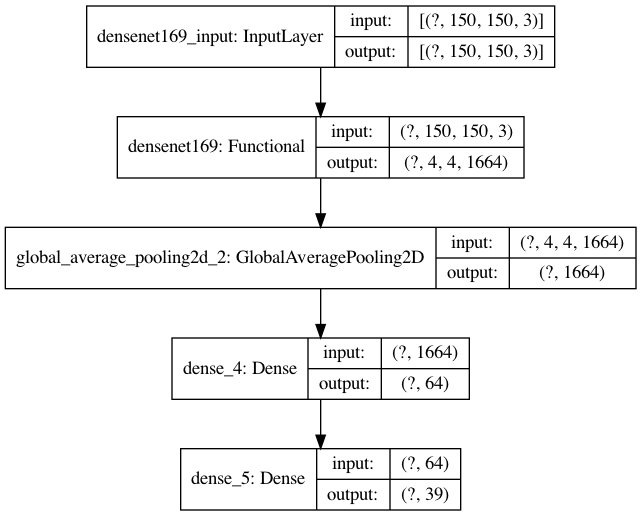

In [24]:
#Plot model to look at the structure
from tensorflow.keras.utils import plot_model
plot_model(dense_loaded_model, to_file='model.png', show_shapes=True, show_layer_names=True)


### Look at train and validation accuracy and loss

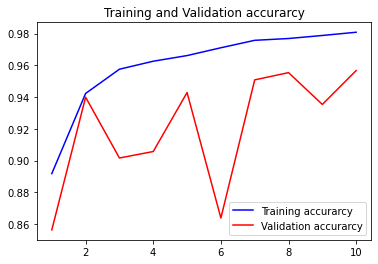

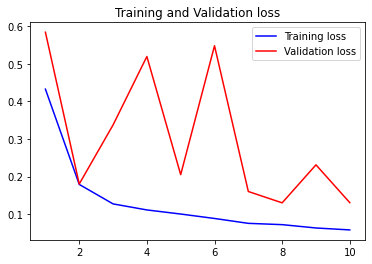

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

## Look at performance on test set

In [28]:
test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_directory(
    test_dir, # Target directory
    target_size=(150, 150), #Resizes all images to 150 × 150
    batch_size=32,
    shuffle = False,
    class_mode='categorical') #Because you use categorical_crossentropy loss, you need categorical labels

Found 6168 images belonging to 39 classes.


In [29]:
dense_loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = dense_loaded_model.evaluate_generator(test_generator, verbose=0)
print("%s: %.2f%%" % (dense_loaded_model.metrics_names[1], score[1]*100))

Instructions for updating:
Please use Model.evaluate, which supports generators.
accuracy: 96.22%


#### The test set has an accuracy score of 96.22% 

In [31]:
train_generator.reset()
validation_generator.reset()

#### Double check results by using the model to make predictions.

Each image is taken in by the model and then probabilities of each class are given to each image. The argmax function returns the class that image has the highest probability of belonging in.

## Confusion matrix

In [54]:
test_generator.reset()

Text(0.5, 255.29374999999993, 'Predicted')

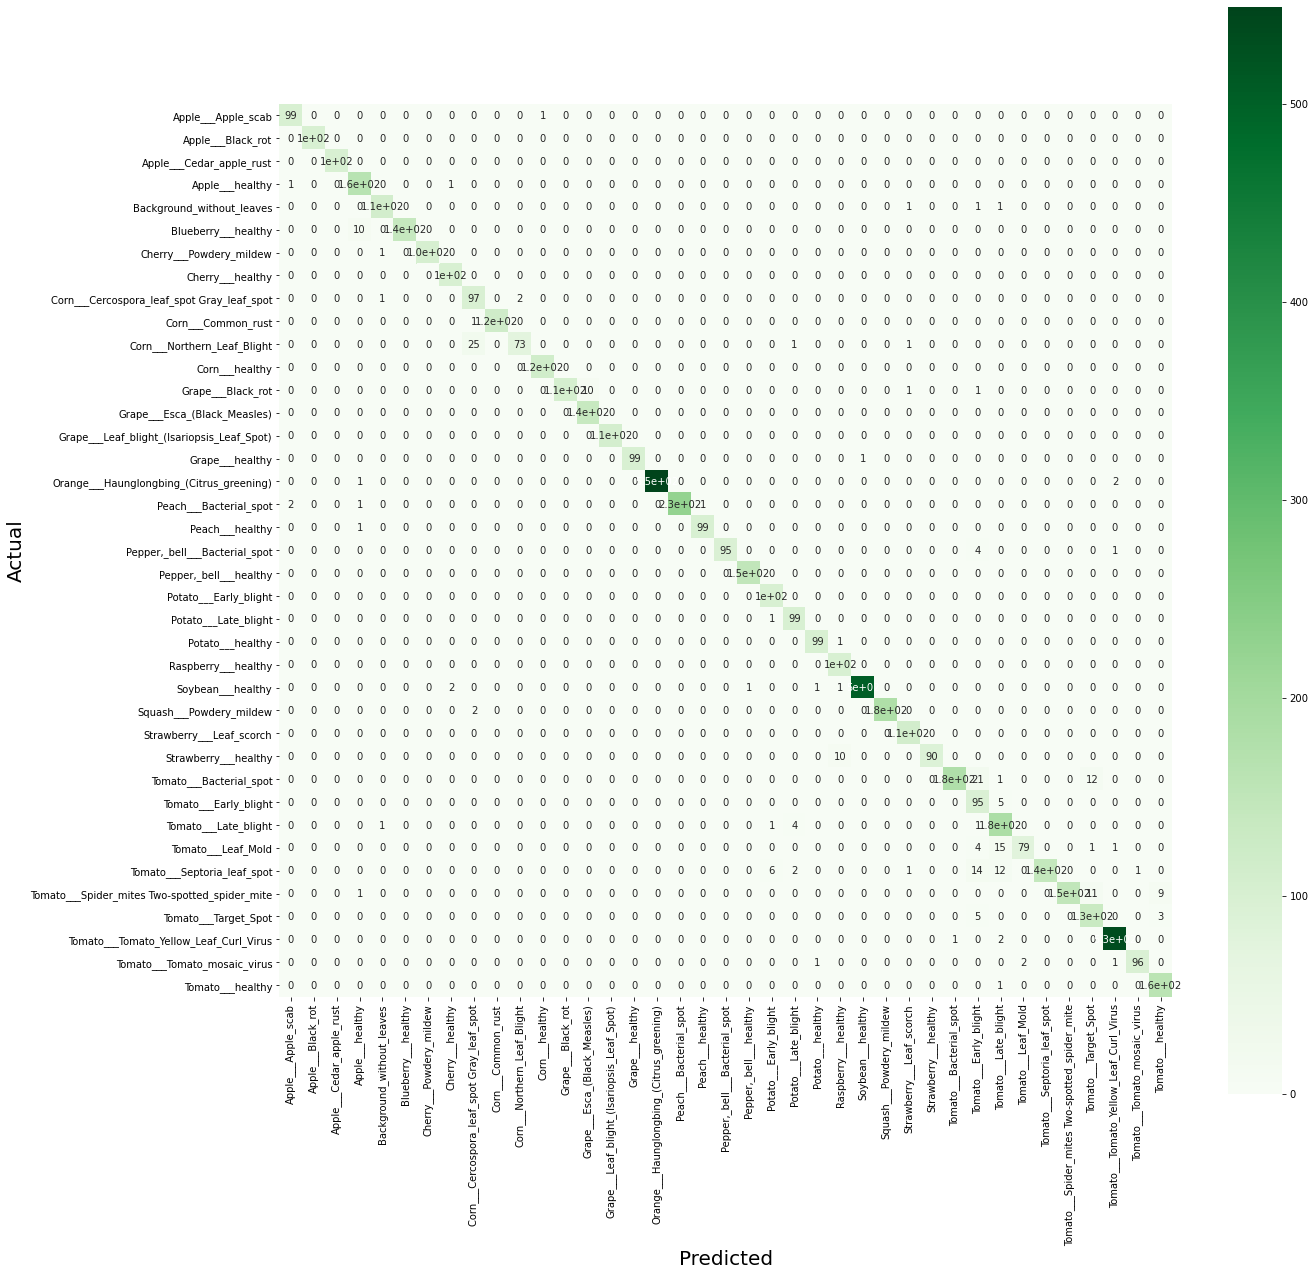

In [60]:
probabilities = dense_loaded_model.predict_generator(test_generator)
Y_true = test_generator.classes
Y_pred = np.argmax(probabilities, axis=1)


cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(20, 20))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=plant_disease, yticklabels=plant_disease)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)


In [61]:
ax.figure.savefig('confusion.jpeg')

## Print classification report

In [51]:
print(classification_report(Y_true, Y_pred, target_names = plant_disease))

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.97      0.99      0.98       100
                            Apple___Black_rot       1.00      1.00      1.00       100
                     Apple___Cedar_apple_rust       1.00      1.00      1.00       100
                              Apple___healthy       0.92      0.99      0.95       165
                    Background_without_leaves       0.97      0.97      0.97       115
                          Blueberry___healthy       1.00      0.93      0.97       151
                      Cherry___Powdery_mildew       1.00      0.99      1.00       106
                             Cherry___healthy       0.97      1.00      0.99       100
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.78      0.97      0.86       100
                           Corn___Common_rust       1.00      0.99      1.00       120
                  Corn___Northern_Leaf_Bli

In [55]:
probabilities = dense_loaded_model.predict_generator(test_generator)
predicted_class_indices=np.argmax(probabilities,axis=1)

#class_indicies returns the class names
#each true label and predicted label are zipped together
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

#create a dataframe with filenames and predictions
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
#results are returned in csv format
results.to_csv("results_dense.csv",index=False)

In [127]:
print(train_generator.class_indices)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Background_without_leaves': 4, 'Blueberry___healthy': 5, 'Cherry___Powdery_mildew': 6, 'Cherry___healthy': 7, 'Corn___Cercospora_leaf_spot Gray_leaf_spot': 8, 'Corn___Common_rust': 9, 'Corn___Northern_Leaf_Blight': 10, 'Corn___healthy': 11, 'Grape___Black_rot': 12, 'Grape___Esca_(Black_Measles)': 13, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 14, 'Grape___healthy': 15, 'Orange___Haunglongbing_(Citrus_greening)': 16, 'Peach___Bacterial_spot': 17, 'Peach___healthy': 18, 'Pepper,_bell___Bacterial_spot': 19, 'Pepper,_bell___healthy': 20, 'Potato___Early_blight': 21, 'Potato___Late_blight': 22, 'Potato___healthy': 23, 'Raspberry___healthy': 24, 'Soybean___healthy': 25, 'Squash___Powdery_mildew': 26, 'Strawberry___Leaf_scorch': 27, 'Strawberry___healthy': 28, 'Tomato___Bacterial_spot': 29, 'Tomato___Early_blight': 30, 'Tomato___Late_blight': 31, 'Tomato___Leaf_Mold': 32, 'Tomato___Septo

In [129]:
#test model on one image
#need to convert the image to an array and into the right dimensions
img = image.load_img('test1.JPG', target_size = (150,150))
y = image.img_to_array(img)
y = np.expand_dims(y, axis = 0)
classes = model.predict_classes(y, batch_size = 10)
print(classes)

[8]


In [43]:
dictionary = train_generator.class_indices
plant_disease = list(dictionary.keys())
plant_disease 

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Background_without_leaves',
 'Blueberry___healthy',
 'Cherry___Powdery_mildew',
 'Cherry___healthy',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust',
 'Corn___Northern_Leaf_Blight',
 'Corn___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot'